## Model Evaluation
*An Evaluation of Google's Perspective API*

### API Set-up

In [11]:
from googleapiclient import discovery
import json, time

API_KEY = 'ENTER API KEY'

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

def analyze_request(comment):
    # ensure only 1 request is made per second
    time.sleep(1)
    body = {
  'comment': { 'text': comment },
  'requestedAttributes': {'TOXICITY': {}}
    }
        
    response = client.comments().analyze(body=body).execute()
    return response['attributeScores']['TOXICITY']['summaryScore']['value']

### Data Import and Cleaning

In [2]:
import pandas as pd

sample_df = pd.read_csv('toxicity_labeled_test_data_sub_sampled.csv')
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

make_numeric = lambda x: 1 if x == 'yes' else 0
sample_df['toxic'] = sample_df['toxic'].apply(make_numeric)

sample_df.head()

,comment_text,toxic
0,Thank you,0
1,dbadvert tag on KPDFCA Wow Doesnt seem to...,0
2,Good Bye Intoronto1125 RIP Hope to see you in...,1
3,You were trying to ban me Perhaps in future yo...,1
4,retarded cousin of the spork,1


### Get Toxicity Scores
The following cell attempts to gather the toxicity score of every `comment_text`. If the API fails to recognize the language of a comment, the row is skipped. Rows without scores are removed from `sample_df`.

In [3]:
tox_scores = []
fails = []
for i, row in sample_df.iterrows():
    try:
        score = analyze_request(row['comment_text'])
        tox_scores.append(score)
    except:
        fails.append(row['comment_text'])

sample_df = sample_df[~sample_df['comment_text'].isin(fails)]

The scores are added to the dataframe in a new column.

In [4]:
sample_df['toxicity_scores'] = tox_scores

sample_df.head()

,comment_text,toxic,toxicity_scores
0,Thank you,0,0.011309
1,dbadvert tag on KPDFCA Wow Doesnt seem to...,0,0.150481
2,Good Bye Intoronto1125 RIP Hope to see you in...,1,0.730815
3,You were trying to ban me Perhaps in future yo...,1,0.507899
4,retarded cousin of the spork,1,0.637829


### Evaluate First Threshold: 0.5
A new column is made to store whether the model's scores fall above the set toxicity threshold of 0.5.

In [5]:
apply_threshold = lambda x: 1 if x > 0.5 else 0

sample_df['toxic_predicted'] = sample_df['toxicity_scores'].apply(apply_threshold)

sample_df.head()

,comment_text,toxic,toxicity_scores,toxic_predicted
0,Thank you,0,0.011309,0
1,dbadvert tag on KPDFCA Wow Doesnt seem to...,0,0.150481,0
2,Good Bye Intoronto1125 RIP Hope to see you in...,1,0.730815,1
3,You were trying to ban me Perhaps in future yo...,1,0.507899,1
4,retarded cousin of the spork,1,0.637829,1


In [6]:
from sklearn.metrics import classification_report

print(classification_report(sample_df['toxic'], sample_df['toxic_predicted']))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       350
           1       0.82      0.92      0.87       140

    accuracy                           0.92       490
   macro avg       0.89      0.92      0.91       490
weighted avg       0.93      0.92      0.92       490



With a 0.5 threshold:
- Out of the comments the model predicted as toxic, only 82% were actually toxic (precision).
- Out of the comments that were actually toxic, 92% were classified as toxic (recall).
- Out of the comments that weren't actually toxic, 92% were classified as not toxic (recall 0).

Recall is more important in this case (since we want to promote a positive online space), so we'll next aim for a threshold with a higher TPR.

### Evaluate Thresholds Using RoC Curve
An RoC curve is created and displayed to analyze the precision and recall of various thresholds.

In [7]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = sample_df['toxic'], y_score = sample_df['toxicity_scores'])

print(f' threshold |     tpr    |      fpr')
for i in range(len(thresholds)):
    # filter to thresholds lower than 0.5 and FPR lower than 0.2
    if thresholds[i] > 0.51 or fpr[i] > 0.2:
        continue
    print(f"{thresholds[i]: ^.8f} | {tpr[i]: ^.8f} | {fpr[i]: ^ .8f}")

 threshold |     tpr    |      fpr
0.50938800 | 0.87857143 |  0.08000000
0.50759226 | 0.89285714 |  0.08000000
0.50247240 | 0.92142857 |  0.08000000
0.49777440 | 0.92142857 |  0.08285714
0.49139655 | 0.92857143 |  0.08285714
0.48021027 | 0.94285714 |  0.08285714
0.47119883 | 0.94285714 |  0.08571429
0.46186632 | 0.95714286 |  0.08571429
0.45090583 | 0.95714286 |  0.09142857
0.44753250 | 0.96428571 |  0.09142857
0.44039994 | 0.96428571 |  0.09714286
0.42985553 | 0.96428571 |  0.11142857
0.42691740 | 0.97142857 |  0.12285714
0.42568782 | 0.97142857 |  0.12571429
0.41910073 | 0.97857143 |  0.12571429
0.40336934 | 0.97857143 |  0.12857143
0.40148460 | 0.97857143 |  0.13714286
0.38601747 | 0.97857143 |  0.14571429
0.37751234 | 0.97857143 |  0.15428571
0.37222690 | 0.97857143 |  0.16285714
0.36662240 | 0.97857143 |  0.16857143
0.36095104 | 0.98571429 |  0.17714286
0.35614890 | 0.98571429 |  0.18000000
0.34757367 | 0.99285714 |  0.18000000
0.32816040 | 0.99285714 |  0.18857143
0.32660890 | 0.

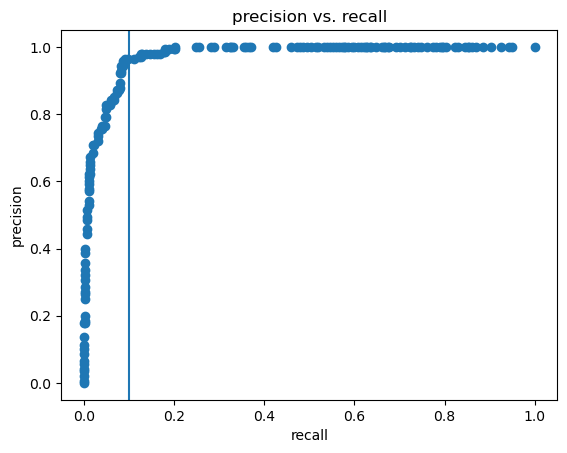

In [8]:
import matplotlib.pyplot as plt

plt.scatter(fpr, tpr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision vs. recall')
plt.axvline(0.1)
plt.show()

Per the RoC curve, a 0.5 threshold had about a 0.92 TPR and 0.08 FPR. This could be considered good if we wanted to be more lax about catching true positives. We want to catch as many true positives as possible, however, so 0.5 is not a good enough threshold.

To balance precision and recall, a threshold of 0.43 will be tested. This should catch around 96% of toxic comments and 10% of non-toxic comments in the filter. In the above scatter plot, this value is also about in the middle of turning point of the RoC curve.

### Evalute New Threshold: 0.43
A new column is made to store whether the model's scores fall above the set toxicity threshold of 0.43.

In [9]:
apply_new_threshold = lambda x: 1 if x > 0.43 else 0

sample_df['toxic_predicted_new'] = sample_df['toxicity_scores'].apply(apply_new_threshold)

sample_df.head()

,comment_text,toxic,toxicity_scores,toxic_predicted,toxic_predicted_new
0,Thank you,0,0.011309,0,0
1,dbadvert tag on KPDFCA Wow Doesnt seem to...,0,0.150481,0,0
2,Good Bye Intoronto1125 RIP Hope to see you in...,1,0.730815,1,1
3,You were trying to ban me Perhaps in future yo...,1,0.507899,1,1
4,retarded cousin of the spork,1,0.637829,1,1


In [10]:
print(classification_report(sample_df['toxic'], sample_df['toxic_predicted_new']))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94       350
           1       0.78      0.96      0.86       140

    accuracy                           0.91       490
   macro avg       0.88      0.93      0.90       490
weighted avg       0.93      0.91      0.91       490



With a .43 threshold:
- Out of the comments the model predicted as toxic, only 78% were actually toxic (precision).
- Out of the comments that were actually toxic, 96% were classified as toxic (recall).
- Out of the comments that weren't actually toxic, 89% were classified as not toxic (recall 0).

Depending on how comments marked as toxic are dealt with, this could be a good threshold to put into practice. The remaining 4% of uncaught toxic comments can be reported by users. If human moderators can be used to confirm the labelling of comments with scores between around 0.5 and 0.43, this would also allow reasonably free expression online and potentially provide further model training points from this grey area. If the threshold is unquestioningly abided by, however, a little over 1 out of 10 non-toxic comments would be flagged, making for a frustrating user experience.